In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the data
with open("log_LOAD_1.txt", "r") as f:
    data = f.readlines()
    columns = data[0].strip().split(', ')
    data = data[1:]

    df = pd.DataFrame([x.strip().split(', ') for x in data], columns=columns)
    
df.tail()

,Position Generated,Velocity Generated,Time
1346,0,0.0,23452
1347,-16777216,-5026.18994140625,23471
1348,-123,-5026.18994140625,23496
1349,-246,-5026.18994140625,23522
1350,-370,-5026.18994140625,23536


In [2]:
with open("logEncoder_LOAD_1.txt", "r") as f:
    data = f.readlines()
    columns = data[0].strip().split(', ')
    data = data[1:]

    df_encoder = pd.DataFrame([x.strip().split(', ') for x in data], columns=columns)

df_encoder.tail()

,Raw Angle,Time
14875,3078,20979
14876,3089,20980
14877,3099,20981
14878,3111,20982
14879,3123,20983


In [3]:
df.shape

(1351, 3)

In [4]:
df_encoder.shape

(14880, 2)

In [5]:
# Convert the data to the correct types
df['Position Generated'] = df['Position Generated'].astype(int)
df['Velocity Generated'] = df['Velocity Generated'].astype(float)
df['Time'] = df['Time'].astype(int)

df_encoder['Raw Angle'] = df_encoder['Raw Angle'].astype(int)
df_encoder['Time'] = df_encoder['Time'].astype(int)

In [6]:
print("Motor Time:", (df['Time'].min(), df['Time'].max()))
print("Encoder Time:", (df_encoder['Time'].min(), df_encoder['Time'].max()))

Motor Time: (8813, 23551)
Encoder Time: (6104, 20983)


In [7]:
# Reset Time to start at 0
df['Time'] = df['Time'] - df['Time'].min()
df_encoder['Time'] = df_encoder['Time'] - df_encoder['Time'].min()

In [8]:
df['Time'] = df['Time'] / 1000
df_encoder['Time'] = df_encoder['Time'] / 1000

In [9]:
print("Motor Time:", (df['Time'].min(), df['Time'].max()))
print("Encoder Time:", (df_encoder['Time'].min(), df_encoder['Time'].max()))

Motor Time: (0.0, 14.738)
Encoder Time: (0.0, 14.879)


In [10]:
# remove 2 last rows
df = df[20:]
df_encoder = df_encoder[200:]

df = df[df['Time'] < 14]
df_encoder = df_encoder[df_encoder['Time'] < 14]

df.reset_index(drop=True, inplace=True)
df_encoder.reset_index(drop=True, inplace=True)

In [11]:
print("Motor Time:", (df['Time'].min(), df['Time'].max()))
print("Encoder Time:", (df_encoder['Time'].min(), df_encoder['Time'].max()))

Motor Time: (0.086, 12.994)
Encoder Time: (0.2, 12.999)


In [12]:
spr = 1600

df['Angle Generated'] = df['Position Generated'].apply(lambda x: x * 360 / spr)
# df['Radian'] = df['Angle'].apply(lambda x: x * 3.14159 / 180)
# df['Velocity'] = df['Velocity'] * (2 * np.pi) / spr
df['Velocity Generated'] = df['Velocity Generated'] * 0.225

In [13]:
df['Acceleration Generated'] = df['Velocity Generated'].diff() / df['Time'].diff()
df['Acceleration Generated'] = df['Acceleration Generated'].fillna(0)

df.head()

,Position Generated,Velocity Generated,Time,Angle Generated,Acceleration Generated
0,0,0.0,0.086,0.0,0.0
1,0,0.0,0.096,0.0,0.0
2,0,0.0,0.124,0.0,0.0
3,0,0.0,0.158,0.0,0.0
4,0,0.0,0.183,0.0,0.0


In [14]:
df_encoder['Raw Angle'].value_counts().idxmax()

2171

<Axes: title={'center': 'Angle vs Time (Encoder)'}, xlabel='Time'>

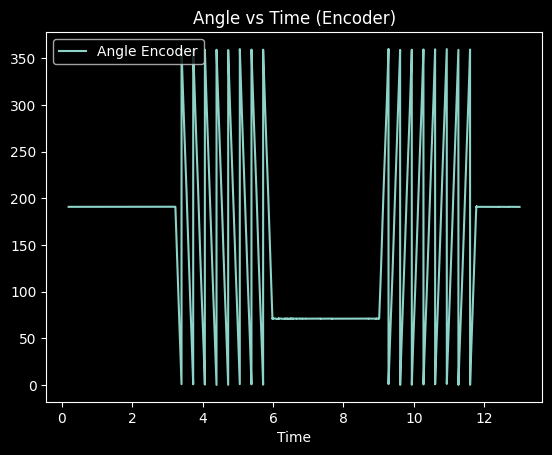

In [15]:
# Map raw angle (0-4095) to degrees (0-360)
df_encoder['Angle Encoder'] = df_encoder['Raw Angle'] / 4095 * 360

df_encoder.plot(x='Time', y='Angle Encoder', title='Angle vs Time (Encoder)')

<Axes: title={'center': 'Angle vs Time (Encoder)'}, xlabel='Time'>

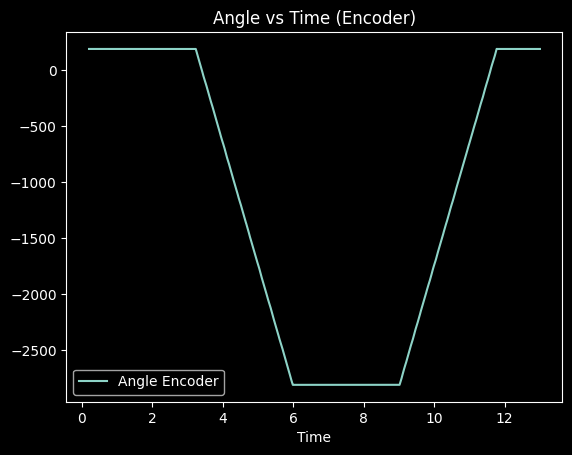

In [16]:
# Continuous angle
continuous_angle = [df_encoder['Angle Encoder'].iloc[0]]

# Calculate into continuous angle
for i in range(1, len(df_encoder)):
    delta_angle = df_encoder['Angle Encoder'][i] - df_encoder['Angle Encoder'][i - 1]
    if delta_angle > 180:
        delta_angle -= 360
    elif delta_angle < -180:
        delta_angle += 360

    continuous_angle.append(continuous_angle[-1] + delta_angle)

df_encoder['Angle Encoder'] = continuous_angle

df_encoder.plot(x='Time', y='Angle Encoder', title='Angle vs Time (Encoder)')

In [17]:
#calibrate the encoder
df_encoder['Angle Encoder'] = df_encoder['Angle Encoder'] - df_encoder['Angle Encoder'].iloc[0]

<Axes: title={'center': 'Angle vs Time (Encoder)'}, xlabel='Time'>

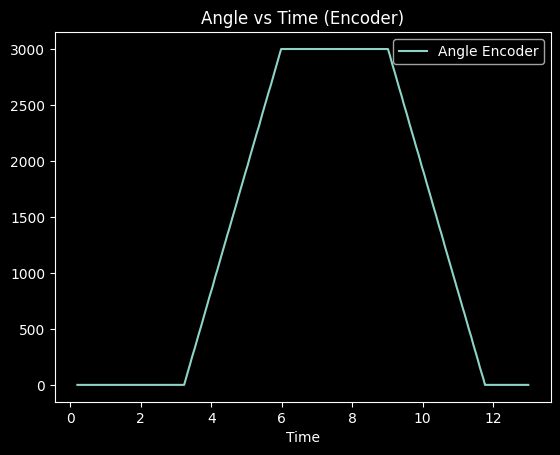

In [18]:
# Change direction of angle
df_encoder['Angle Encoder'] = -df_encoder['Angle Encoder']

df_encoder.plot(x='Time', y='Angle Encoder', title='Angle vs Time (Encoder)')

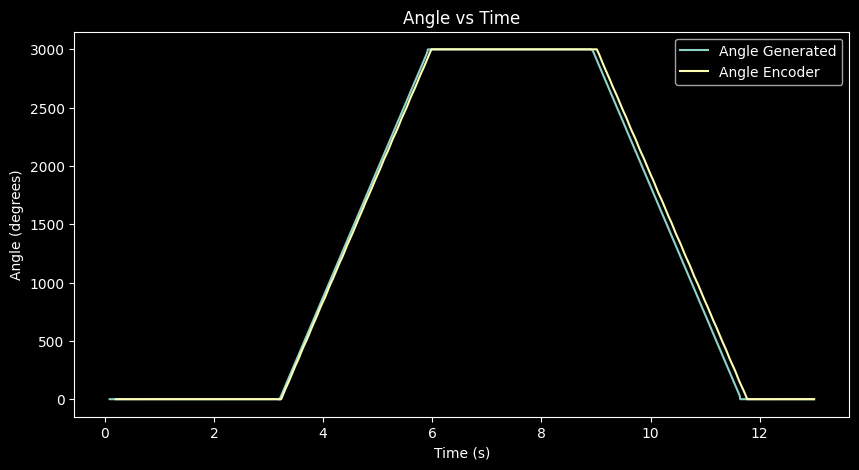

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(df['Time'], df['Angle Generated'], label='Angle Generated')
ax.plot(df_encoder['Time'], df_encoder['Angle Encoder'], label='Angle Encoder')

ax.set_title('Angle vs Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (degrees)')

ax.legend()

In [20]:
# dfEncoder['Radian'] = np.deg2rad(dfEncoder['Angle'])
# dfEncoder['Velocity'] = dfEncoder['Radian'].diff() / dfEncoder['Time'].diff()
df_encoder['Velocity Encoder'] = df_encoder['Angle Encoder'].diff() / df_encoder['Time'].diff()
df_encoder['Velocity Encoder'] = df_encoder['Velocity Encoder'].fillna(0)

df_encoder['Acceleration Encoder'] = df_encoder['Velocity Encoder'].diff() / df_encoder['Time'].diff()
df_encoder['Acceleration Encoder'] = df_encoder['Acceleration Encoder'].fillna(0)

df_encoder.head()

,Raw Angle,Time,Angle Encoder,Velocity Encoder,Acceleration Encoder
0,2171,0.200,-0.000000,0.000000,0.000000
1,2171,0.201,-0.000000,0.000000,0.000000
2,2171,0.202,-0.000000,0.000000,0.000000
3,2170,0.203,0.087912,87.912088,87912.087912
4,2171,0.204,-0.000000,-87.912088,-175824.175824


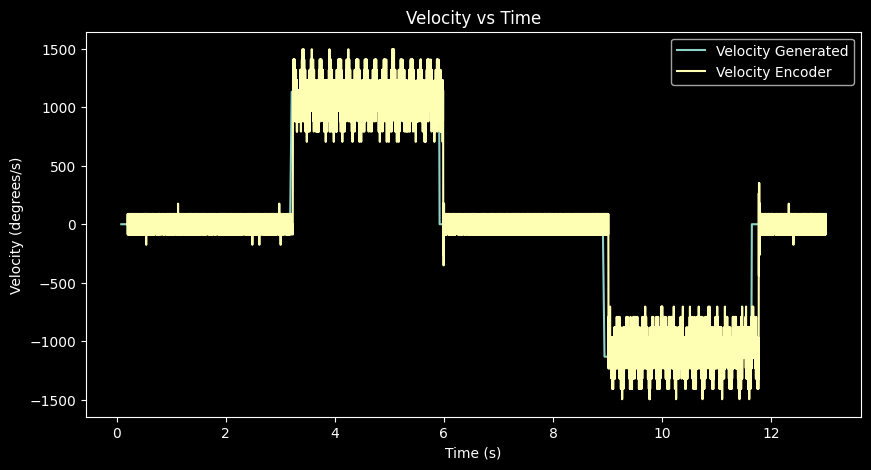

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(df['Time'], df['Velocity Generated'], label='Velocity Generated')
ax.plot(df_encoder['Time'], df_encoder['Velocity Encoder'], label='Velocity Encoder')

ax.set_title('Velocity vs Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (degrees/s)')

ax.legend()

In [22]:
# columnsDF = ['Position', 'Angle', 'Radian', 'Velocity', 'Acceleration', 'Started', 'Time']
# columnsDFEncoder = ['Raw Angle', 'Angle', 'Radian', 'Velocity', 'Acceleration', 'Match Flag', 'Started', 'Time']

columnsDF = ['Position Generated', 'Angle Generated', 'Velocity Generated', 'Acceleration Generated', 'Time']
columnsDFEncoder = ['Raw Angle', 'Angle Encoder', 'Velocity Encoder', 'Acceleration Encoder', 'Time']

df = df[columnsDF]
df_encoder = df_encoder[columnsDFEncoder]

# **GRAPH**

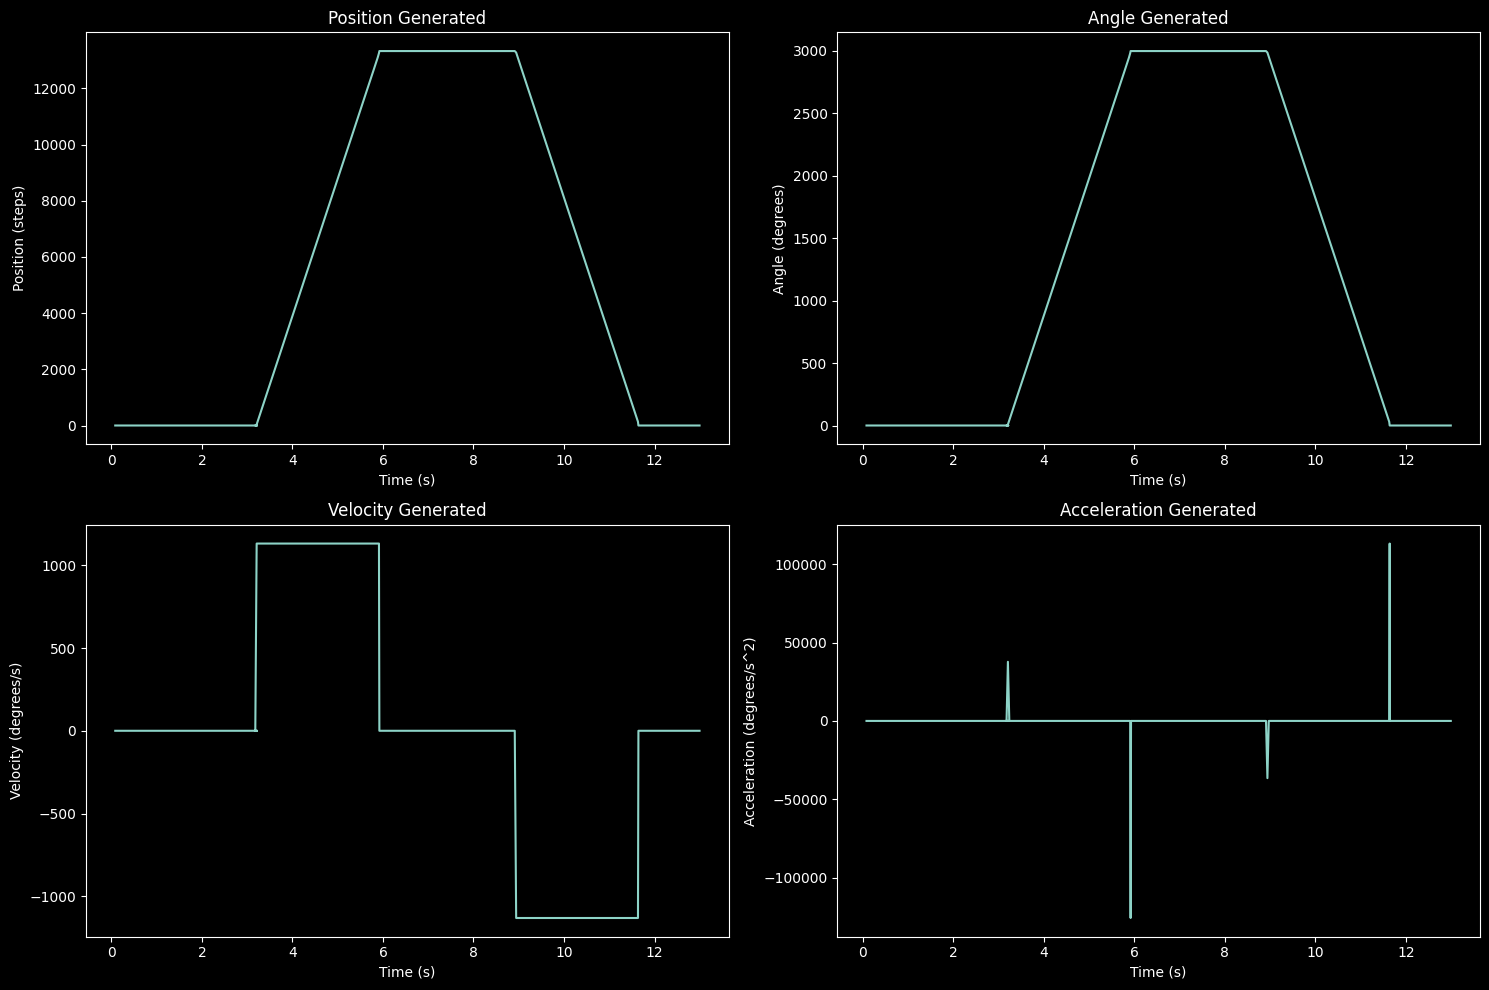

In [23]:
units = ['steps', 'degrees', 'degrees/s', 'degrees/s^2', 's']

fig, ax = plt.subplots((len(columnsDF)) // 2, 2, figsize=(15, 10))
for i, col in enumerate(columnsDF):
    if col == 'Time':
        continue
    ax[i // 2, i % 2].plot(df['Time'], df[col])
    ax[i // 2, i % 2].set_title(col)
    ax[i // 2, i % 2].set_xlabel('Time (s)')
    ax[i // 2, i % 2].set_ylabel(col.split(' ')[0] + ' (' + units[i] + ')')

fig.tight_layout()

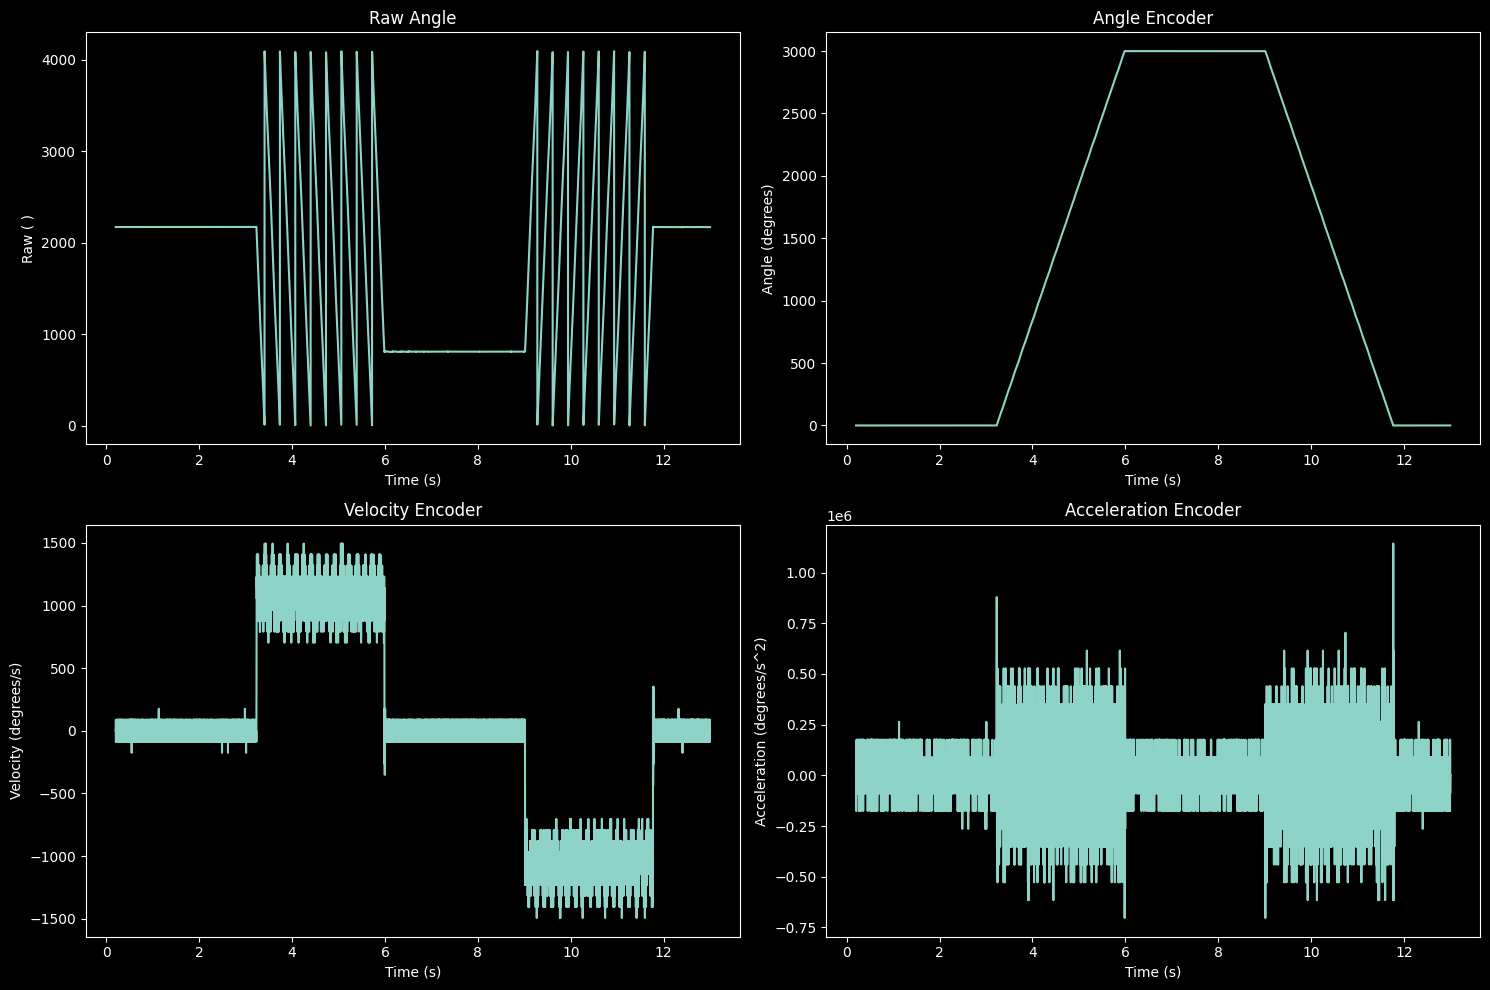

In [24]:
units = [' ', 'degrees', 'degrees/s', 'degrees/s^2', 's']

fig, ax = plt.subplots((len(columnsDFEncoder)) // 2, 2, figsize=(15, 10))
for i, col in enumerate(columnsDFEncoder):
    if col == 'Time':
        continue
    ax[i // 2, i % 2].plot(df_encoder['Time'], df_encoder[col])
    ax[i // 2, i % 2].set_title(col)
    ax[i // 2, i % 2].set_xlabel('Time (s)')
    ax[i // 2, i % 2].set_ylabel(col.split(' ')[0] + ' (' + units[i] + ')')

fig.tight_layout()

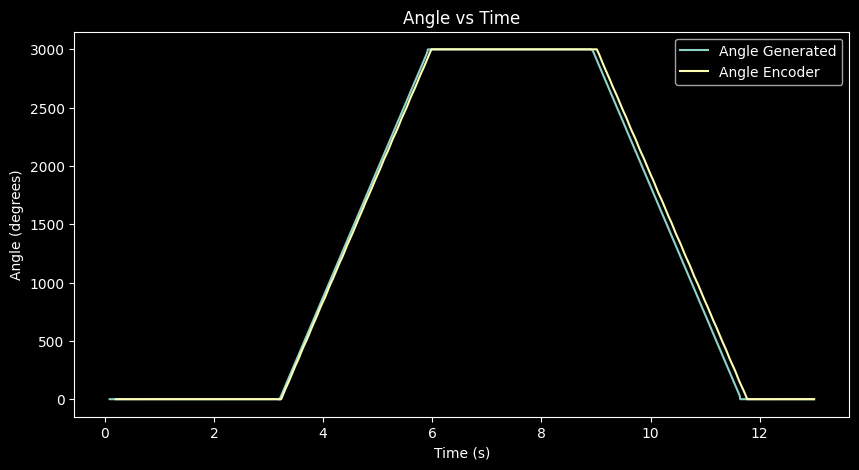

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(df['Time'], df['Angle Generated'], label='Angle Generated')
ax.plot(df_encoder['Time'], df_encoder['Angle Encoder'], label='Angle Encoder')

ax.set_title('Angle vs Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (degrees)')
ax.legend()

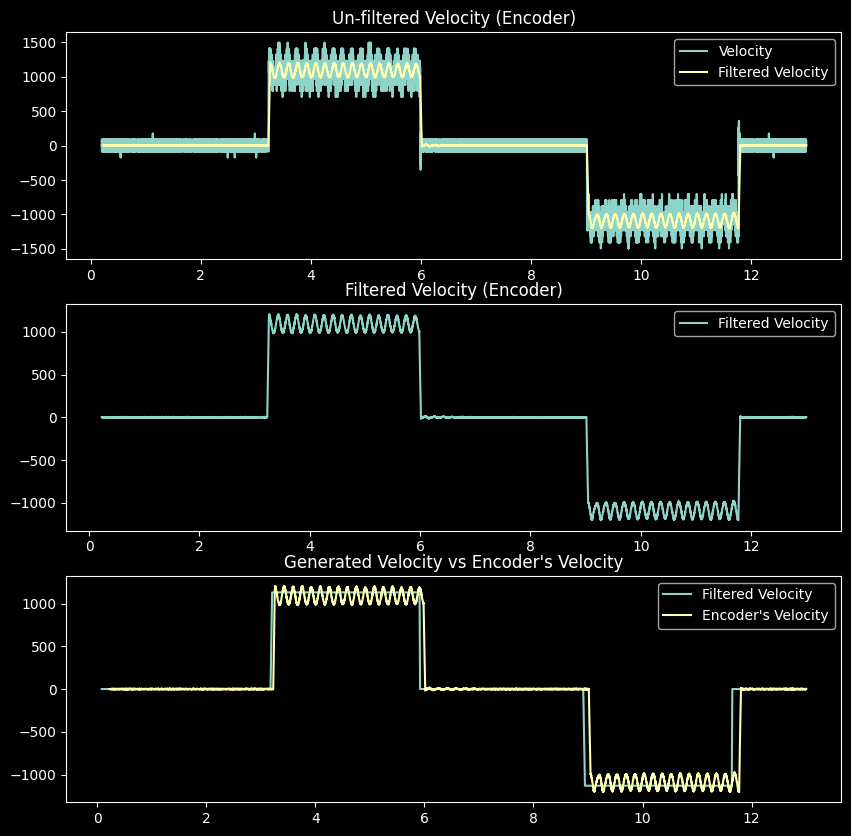

In [26]:
dfCopy = df_encoder.copy()

# Apply filter to velocity
dfCopy['Velocity Encoder Filtered'] = dfCopy['Velocity Encoder'].rolling(window=30).mean()

fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(dfCopy['Time'], dfCopy['Velocity Encoder'])
ax[0].plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])
ax[1].plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])
ax[2].plot(df['Time'], df['Velocity Generated'])
ax[2].plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])

ax[0].set_title('Un-filtered Velocity (Encoder)')
ax[1].set_title('Filtered Velocity (Encoder)')
ax[2].set_title('Generated Velocity vs Encoder\'s Velocity')

ax[0].legend(['Velocity', 'Filtered Velocity'])
ax[1].legend(['Filtered Velocity'])
ax[2].legend(['Filtered Velocity', 'Encoder\'s Velocity'])

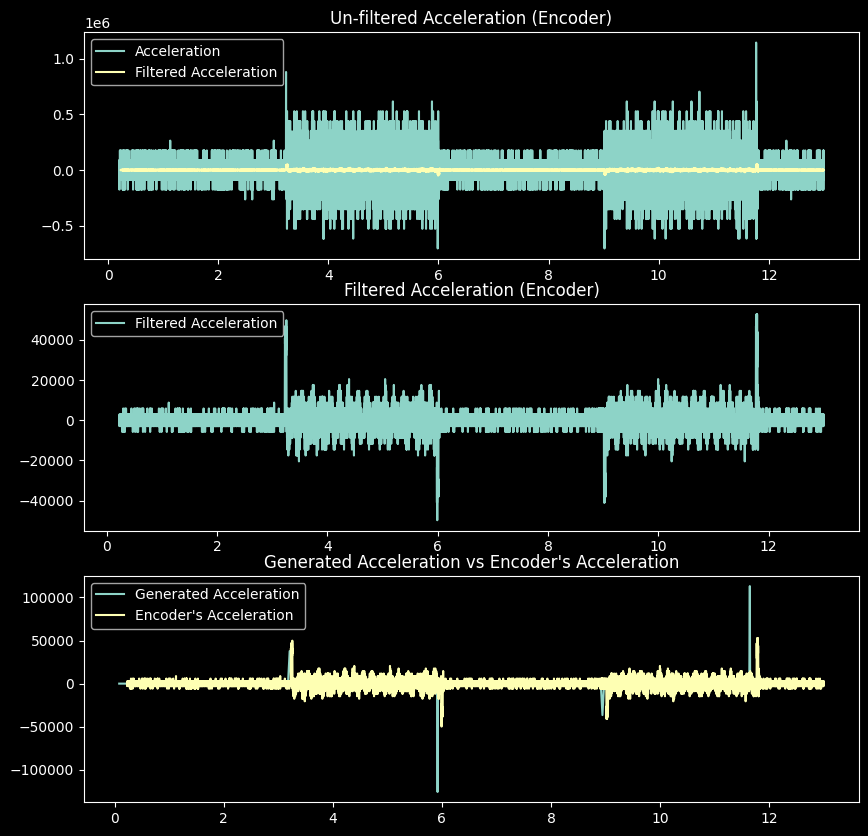

In [27]:
dfCopy['Acceleration Encoder Filtered'] = dfCopy['Acceleration Encoder'].rolling(window=30).mean()

fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(dfCopy['Time'], dfCopy['Acceleration Encoder'])
ax[0].plot(dfCopy['Time'], dfCopy['Acceleration Encoder Filtered'])
ax[1].plot(dfCopy['Time'], dfCopy['Acceleration Encoder Filtered'])
ax[2].plot(df['Time'], df['Acceleration Generated'])
ax[2].plot(dfCopy['Time'], dfCopy['Acceleration Encoder Filtered'])

ax[0].set_title('Un-filtered Acceleration (Encoder)')
ax[1].set_title('Filtered Acceleration (Encoder)')
ax[2].set_title('Generated Acceleration vs Encoder\'s Acceleration')

ax[0].legend(['Acceleration', 'Filtered Acceleration'])
ax[1].legend(['Filtered Acceleration'])
ax[2].legend(['Generated Acceleration', 'Encoder\'s Acceleration'])

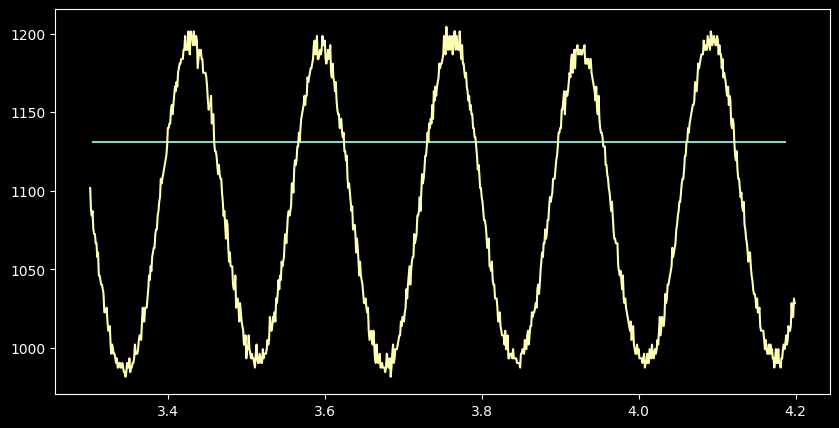

In [28]:
df_3_4 = df[(df['Time'] > 3.3) & (df['Time'] < 4.2)]
df_encoder_3_4 = dfCopy[(dfCopy['Time'] > 3.3) & (dfCopy['Time'] < 4.2)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(df_3_4['Time'], df_3_4['Velocity Generated'], label='Velocity Generated')
ax.plot(df_encoder_3_4['Time'], df_encoder_3_4['Velocity Encoder Filtered'], label='Velocity Encoder Filtered')

In [29]:
df_encoder_3_4['Velocity Encoder Filtered'].mean()

1083.1082154775154

In [30]:
df.max()

Position Generated         13327.000000
Angle Generated             2998.575000
Velocity Generated          1130.892737
Acceleration Generated    113089.273682
Time                          12.994000
dtype: float64

In [31]:
dfCopy.max()

Raw Angle                        4.095000e+03
Angle Encoder                    3.000176e+03
Velocity Encoder                 1.494505e+03
Acceleration Encoder             1.142857e+06
Time                             1.299900e+01
Velocity Encoder Filtered        1.204396e+03
Acceleration Encoder Filtered    5.274725e+04
dtype: float64